In [1]:
import pandas as pd

df = pd.read_csv("SummerTrainingGenera_DATA_2025-11-19_1620 updated.csv")

In [2]:
df.columns.tolist()

['subject_id',
 'redcap_event_name',
 'redcap_survey_identifier',
 'email',
 'email_complete',
 'study_id',
 'study_id_complete',
 'organizational_implementation_context_series_oic_l_complete',
 'general_background_information_timestamp',
 'datasource',
 'date',
 'county_of_school',
 'school_district',
 'primary_role',
 'specify_role',
 'grade___1',
 'grade___2',
 'grade___3',
 'grade___4',
 'grade___5',
 'grade___6',
 'grade___999',
 'years_working_asd',
 'years_working_special_ed',
 'educational_setting',
 'specify_setting',
 'hands_trainings___1',
 'hands_trainings___2',
 'hands_trainings___3',
 'hands_trainings___4',
 'hands_trainings___5',
 'hands_trainings___999',
 'other_hands_trainings',
 'not_hands_trainings___1',
 'not_hands_trainings___2',
 'not_hands_trainings___3',
 'not_hands_trainings___4',
 'not_hands_trainings___5',
 'not_hands_trainings___6',
 'not_hands_trainings___7',
 'not_hands_trainings___999',
 'other_trainings',
 'national_format___1',
 'national_format___2',
 


===== AKS SUMMARY =====
{'N_pre': 30, 'N_post': 30, 'N_matched': 30, 'Mean_pre': 11.196466666666668, 'Mean_post': 13.675033333333335, 'Mean_change': 2.4785666666666657, 'Cronbach_alpha_pre': 0.4450104924174775, 'Cronbach_alpha_post': 0.9999978305625095, 'Cohens_d': 0.6409070630149679, 'Correlation_pre_post': 0.5800521905046321}


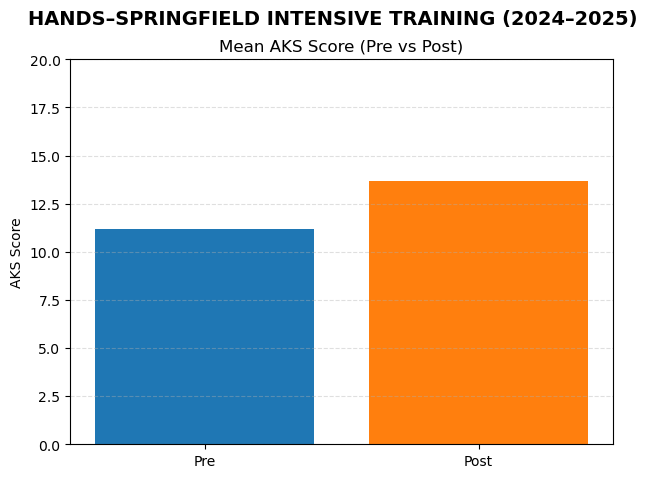

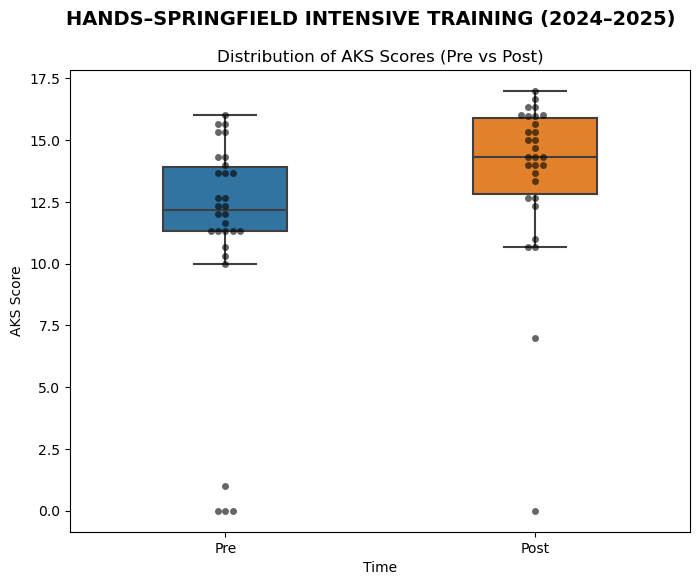

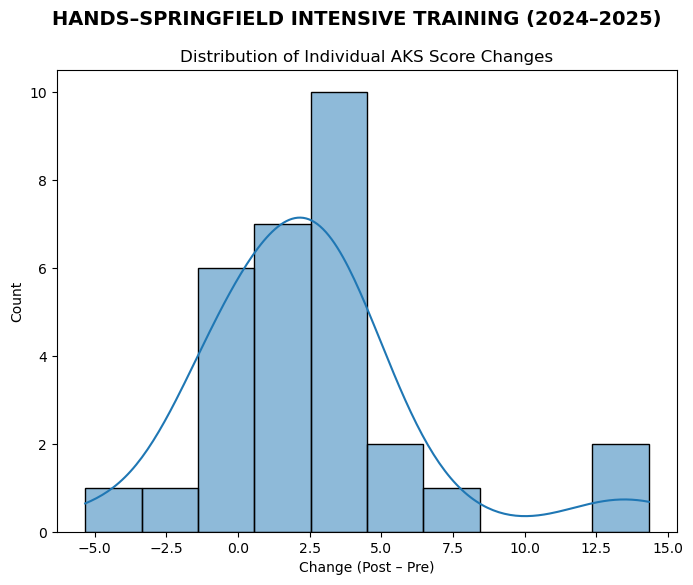

Saved: hands_plots/mean_daily_satisfaction.png


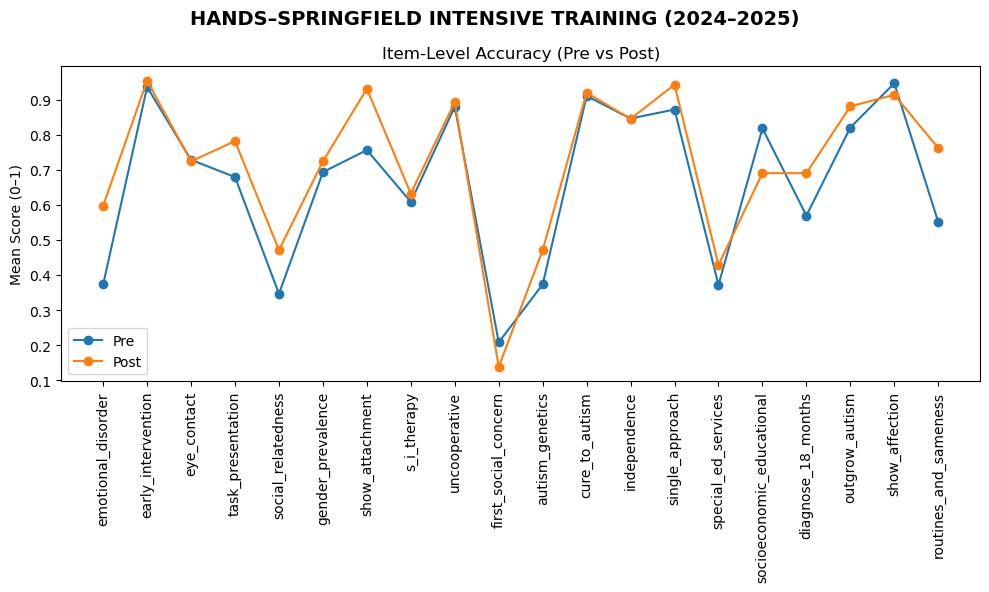

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

# ----------------------------------------------------
# 1. Load Data
# ----------------------------------------------------
SAVE_FOLDER = "hands_plots"
os.makedirs(SAVE_FOLDER, exist_ok=True)

def save_plot(name=None):
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        name = f"plot_{timestamp}.png"
    path = os.path.join(SAVE_FOLDER, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved: {path}")
# ----------------------------------------------------
# 2. AKS Items & Correct Answers
# ----------------------------------------------------

aks_items = [
    'emotional_disorder', 'early_intervention', 'eye_contact', 'task_presentation',
    'social_relatedness', 'gender_prevalence', 'show_attachment', 's_i_therapy',
    'uncooperative', 'first_social_concern', 'autism_genetics', 'cure_to_autism',
    'independence', 'single_approach', 'special_ed_services', 'socioeconomic_educational',
    'diagnose_18_months', 'outgrow_autism', 'show_affection', 'routines_and_sameness'
]

correct = {
    'emotional_disorder': 6, 'early_intervention': 1, 'eye_contact': 6, 'task_presentation': 1,
    'social_relatedness': 1, 'gender_prevalence': 1, 'show_attachment': 6, 's_i_therapy': 1,
    'uncooperative': 6, 'first_social_concern': 6, 'autism_genetics': 1, 'cure_to_autism': 6,
    'independence': 1, 'single_approach': 6, 'special_ed_services': 1,
    'socioeconomic_educational': 6, 'diagnose_18_months': 1, 'outgrow_autism': 6,
    'show_affection': 6, 'routines_and_sameness': 1
}

# ----------------------------------------------------
# NEW SCORING FUNCTION (Exactly as requested!)
# ----------------------------------------------------
def score_item(val, correct_val):
    """
    Correct answer = 1.0
    1 step away = 0.666
    2 steps away = 0.333
    3+ steps away = 0
    """
    if val == 999 or pd.isna(val):
        return np.nan
        
    distance = abs(val - correct_val)

    if distance == 0:
        return 1.0
    elif distance == 1:
        return 0.666
    elif distance == 2:
        return 0.333
    else:
        return 0

# Score AKS items
for item in aks_items:
    df[item + "_score"] = df[item].apply(lambda x: score_item(x, correct[item]))

df["aks_total"] = df[[i + "_score" for i in aks_items]].sum(axis=1)

# ----------------------------------------------------
# 3. Pre/Post Split
# ----------------------------------------------------
pre_event = "pretraining_measur_arm_1"
post_event = "posttraining_measu_arm_1"

df_pre = df[df["redcap_event_name"] == pre_event]
df_post = df[df["redcap_event_name"] == post_event]

# ----------------------------------------------------
# 4. Merge Matched Participants
# ----------------------------------------------------
merged = pd.merge(
    df_pre[["subject_id", "aks_total"]],
    df_post[["subject_id", "aks_total"]],
    on="subject_id",
    suffixes=("_pre", "_post")
)

# ----------------------------------------------------
# 5. Cronbach Alpha
# ----------------------------------------------------
def cronbach_alpha(df_items):
    df_items = df_items.dropna(axis=0)
    item_vars = df_items.var(axis=0, ddof=1)
    total_var = df_items.sum(axis=1).var(ddof=1)
    n = df_items.shape[1]
    return (n/(n-1)) * (1 - item_vars.sum()/total_var)

alpha_pre = cronbach_alpha(df_pre[aks_items])
alpha_post = cronbach_alpha(df_post[aks_items])

# ----------------------------------------------------
# 6. Effect Size (Cohen’s d)
# ----------------------------------------------------
def cohens_d(pre, post):
    diff = post - pre
    return diff.mean() / diff.std(ddof=1)

d_value = cohens_d(merged["aks_total_pre"], merged["aks_total_post"])

# ----------------------------------------------------
# 7. Correlation
# ----------------------------------------------------
correlation = merged["aks_total_pre"].corr(merged["aks_total_post"])

# ----------------------------------------------------
# 8. Summary Stats
# ----------------------------------------------------
summary = {
    "N_pre": len(df_pre),
    "N_post": len(df_post),
    "N_matched": len(merged),
    "Mean_pre": merged["aks_total_pre"].mean(),
    "Mean_post": merged["aks_total_post"].mean(),
    "Mean_change": (merged["aks_total_post"] - merged["aks_total_pre"]).mean(),
    "Cronbach_alpha_pre": alpha_pre,
    "Cronbach_alpha_post": alpha_post,
    "Cohens_d": d_value,
    "Correlation_pre_post": correlation
}

print("\n===== AKS SUMMARY =====")
print(summary)

# ----------------------------------------------------
# 9. Bar Chart (Mean Pre vs Post)
# ----------------------------------------------------
plt.figure(figsize=(7,5))
plt.suptitle("HANDS–SPRINGFIELD INTENSIVE TRAINING (2024–2025)", fontsize=14, fontweight="bold")
plt.bar(["Pre", "Post"], [summary["Mean_pre"], summary["Mean_post"]], color=["#1f77b4", "#ff7f0e"])
plt.title("Mean AKS Score (Pre vs Post)")
plt.ylabel("AKS Score")
plt.ylim(0, 20)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.show()

# ----------------------------------------------------
# 10. Boxplot + Beeswarm
# ----------------------------------------------------
long_df = pd.DataFrame({
    "Score": pd.concat([merged["aks_total_pre"], merged["aks_total_post"]], ignore_index=True),
    "Time": ["Pre"] * len(merged) + ["Post"] * len(merged)
})

plt.figure(figsize=(8,6))
plt.suptitle("HANDS–SPRINGFIELD INTENSIVE TRAINING (2024–2025)", fontsize=14, fontweight="bold")
sns.boxplot(x="Time", y="Score", data=long_df, width=0.4, showfliers=False)
sns.swarmplot(x="Time", y="Score", data=long_df, color="black", alpha=0.6)
plt.title("Distribution of AKS Scores (Pre vs Post)")
plt.ylabel("AKS Score")
plt.show()

# ----------------------------------------------------
# 11. Histogram of Score Change
# ----------------------------------------------------
merged["change"] = merged["aks_total_post"] - merged["aks_total_pre"]

plt.figure(figsize=(8,6))
plt.suptitle("HANDS–SPRINGFIELD INTENSIVE TRAINING (2024–2025)", fontsize=14, fontweight="bold")
sns.histplot(merged["change"], kde=True, bins=10)
plt.title("Distribution of Individual AKS Score Changes")
plt.xlabel("Change (Post – Pre)")
plt.ylabel("Count")
plt.show()

# ----------------------------------------------------
# 12. Item-Level Difficulty
# ----------------------------------------------------
item_accuracy_pre = df_pre[[i + "_score" for i in aks_items]].mean()
item_accuracy_post = df_post[[i + "_score" for i in aks_items]].mean()

plt.figure(figsize=(10,6))
plt.suptitle("HANDS–SPRINGFIELD INTENSIVE TRAINING (2024–2025)", fontsize=14, fontweight="bold")
plt.plot(item_accuracy_pre.values, label="Pre", marker="o")
plt.plot(item_accuracy_post.values, label="Post", marker="o")
plt.xticks(range(len(aks_items)), aks_items, rotation=90)
plt.title("Item-Level Accuracy (Pre vs Post)")
plt.ylabel("Mean Score (0–1)")
save_plot("mean_daily_satisfaction.png")
plt.legend()
plt.tight_layout()
plt.show()

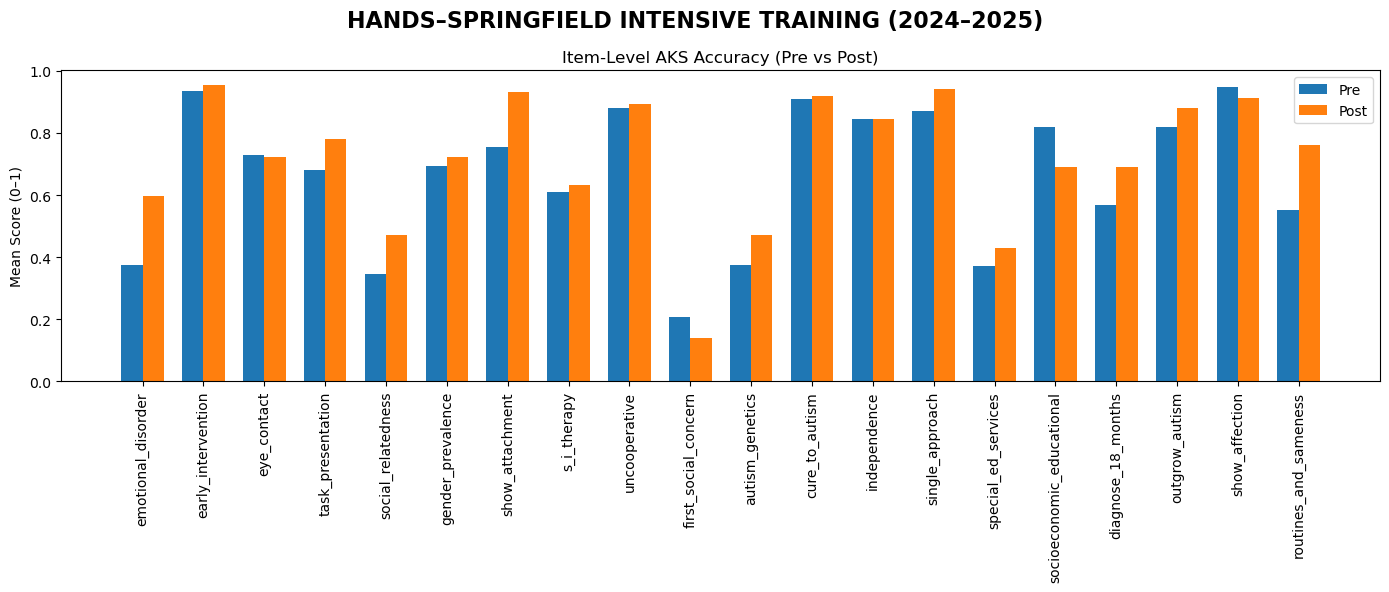

In [4]:
import numpy as np
import matplotlib.pyplot as plt

pre_scores = item_accuracy_pre.values
post_scores = item_accuracy_post.values

x = np.arange(len(aks_items))
width = 0.35

plt.figure(figsize=(14,6))
plt.suptitle("HANDS–SPRINGFIELD INTENSIVE TRAINING (2024–2025)", fontsize=16, fontweight="bold")

plt.bar(x - width/2, pre_scores, width, label="Pre", color="#1f77b4")
plt.bar(x + width/2, post_scores, width, label="Post", color="#ff7f0e")

plt.xticks(x, aks_items, rotation=90)
plt.ylabel("Mean Score (0–1)")
plt.title("Item-Level AKS Accuracy (Pre vs Post)")
plt.legend()

plt.tight_layout()
plt.show()

Saved: hands_plots/mean_daily_satisfaction.png


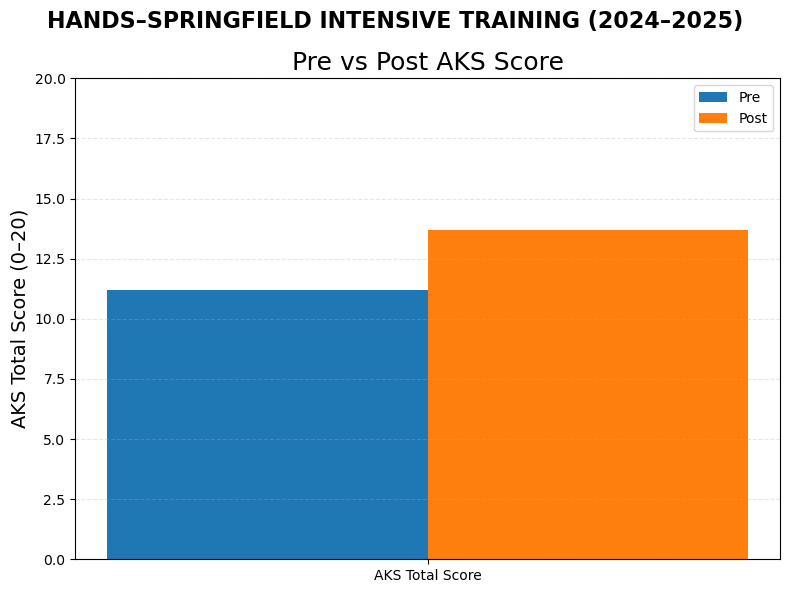

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Values
pre = summary["Mean_pre"]
post = summary["Mean_post"]

labels = ["AKS Total Score"]
x = np.arange(len(labels))  # 1 category
width = 0.35  # bar width

plt.figure(figsize=(8,6))
plt.suptitle("HANDS–SPRINGFIELD INTENSIVE TRAINING (2024–2025)", fontsize=16, fontweight="bold")

# Bars
plt.bar(x - width/2, pre, width, label="Pre", color="#1f77b4")
plt.bar(x + width/2, post, width, label="Post", color="#ff7f0e")

# Labels on top

plt.ylabel("AKS Total Score (0–20)", fontsize=14)
plt.title("Pre vs Post AKS Score", fontsize=18)

plt.ylim(0, 20)
plt.xticks(x, labels)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.3)
save_plot("mean_daily_satisfaction.png")
plt.tight_layout()
plt.show()

Saved: hands_plots/mean_daily_satisfaction.png


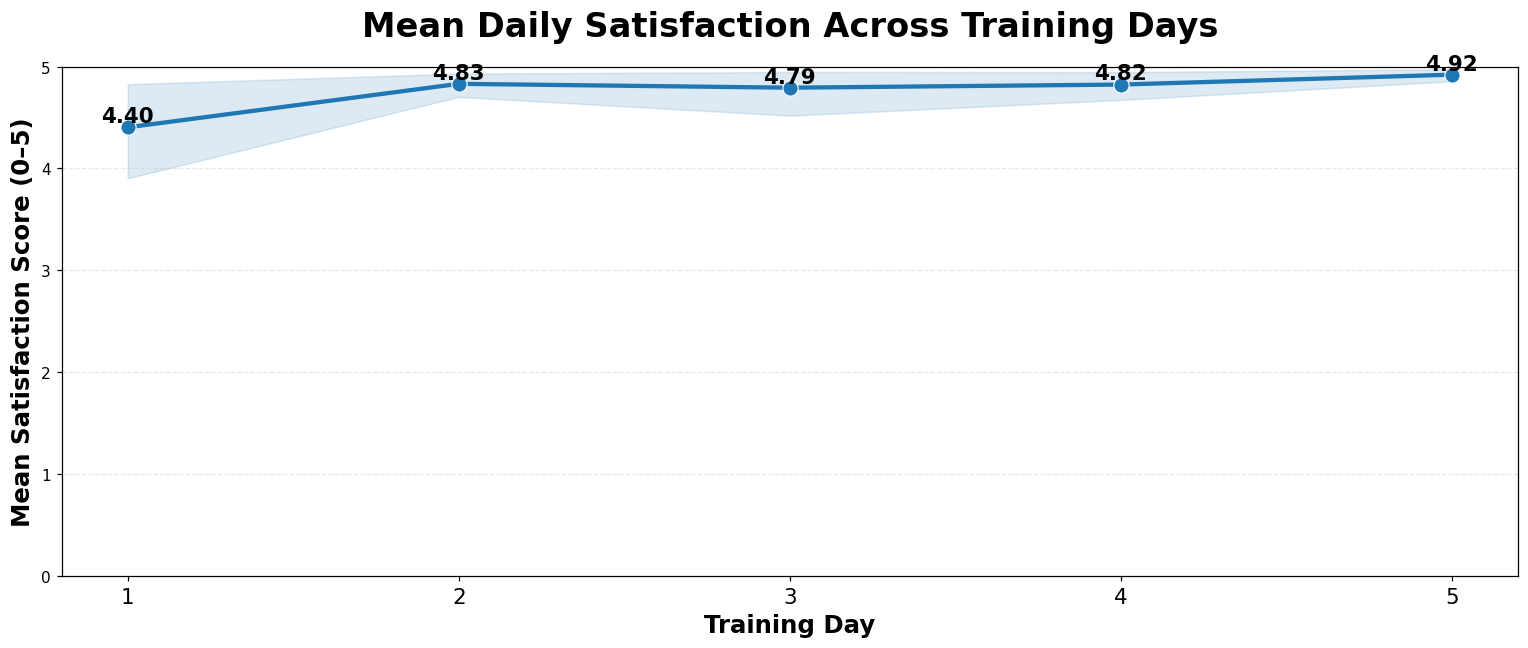

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

SAVE_FOLDER = "hands_plots"
os.makedirs(SAVE_FOLDER, exist_ok=True)

def save_plot(name=None):
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        name = f"plot_{timestamp}.png"
    path = os.path.join(SAVE_FOLDER, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved: {path}")
# ----------------------------------------------------
# 1. Compute Means
# ----------------------------------------------------
means = df_daily.groupby("Training_Day")["daily_satisfaction"].mean().dropna()

# ----------------------------------------------------
# 2. Plot
# ----------------------------------------------------
plt.figure(figsize=(14, 6), dpi=110)

sns.lineplot(
    data=df_daily,
    x="Training_Day",
    y="daily_satisfaction",
    estimator="mean",
    errorbar=("ci", 95),
    marker="o",
    markersize=10,
    linewidth=2.8,
    color="#1f77b4",
    err_kws={"alpha": 0.15}
)

# ----------------------------------------------------
# 3. Annotate point values
# ----------------------------------------------------
ax = plt.gca()
for day, val in means.items():
    ax.text(day, val + 0.05, f"{val:.2f}", ha="center", fontsize=14, weight="bold")

# ----------------------------------------------------
# 4. Fix X-axis to show ONLY day numbers (1–5)
# ----------------------------------------------------
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels(["1", "2", "3", "4", "5"], fontsize=14)

# ----------------------------------------------------
# 5. Titles and Labels
# ----------------------------------------------------

plt.title("Mean Daily Satisfaction Across Training Days", fontsize=22, weight="bold", pad=20)
plt.xlabel("Training Day", fontsize=16, weight="bold")
plt.ylabel("Mean Satisfaction Score (0–5)", fontsize=16, weight="bold")

plt.ylim(0, 5)
plt.grid(axis="y", linestyle="--", alpha=0.3)
save_plot("mean_daily_satisfaction.png")
plt.tight_layout()
plt.show()

In [31]:
# List of daily satisfaction items
daily_items = [
    'goals_outlined','lecture_goals','small_groups','classroom_practice','lecture_interest',
    'video_media','activity_interest','speaker_knowledge','applicable_material',
    'informative_handouts','observe_staff','practice_skills','informative_feedback',
    'large_group','overall_impression'
]

# Clean: Replace 999 with NaN and convert to numeric
df_clean = df.copy()
df_clean[daily_items] = df_clean[daily_items].replace(999, np.nan).apply(pd.to_numeric, errors='coerce')

# Remove rows where ALL daily items are missing
df_daily_eval = df_clean.dropna(subset=daily_items, how='all')

df_daily_eval[daily_items].describe()

,goals_outlined,lecture_goals,small_groups,classroom_practice,lecture_interest,video_media,activity_interest,speaker_knowledge,applicable_material,informative_handouts,observe_staff,practice_skills,informative_feedback,large_group,overall_impression
count,122.000000,120.000000,120.000000,122.000000,123.000000,123.000000,123.000000,123.000000,123.000000,120.000000,122.000000,123.000000,123.000000,123.000000,121.000000
mean,4.786885,4.791667,4.783333,4.893443,4.536585,4.682927,4.674797,4.813008,4.780488,4.800000,4.844262,4.780488,4.780488,4.707317,4.793388
std,0.729876,0.732164,0.700340,0.665655,0.832660,0.716516,0.773495,0.681724,0.634223,0.655936,0.704419,0.730333,0.671878,0.732520,0.546464
min,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,5.000000,5.000000


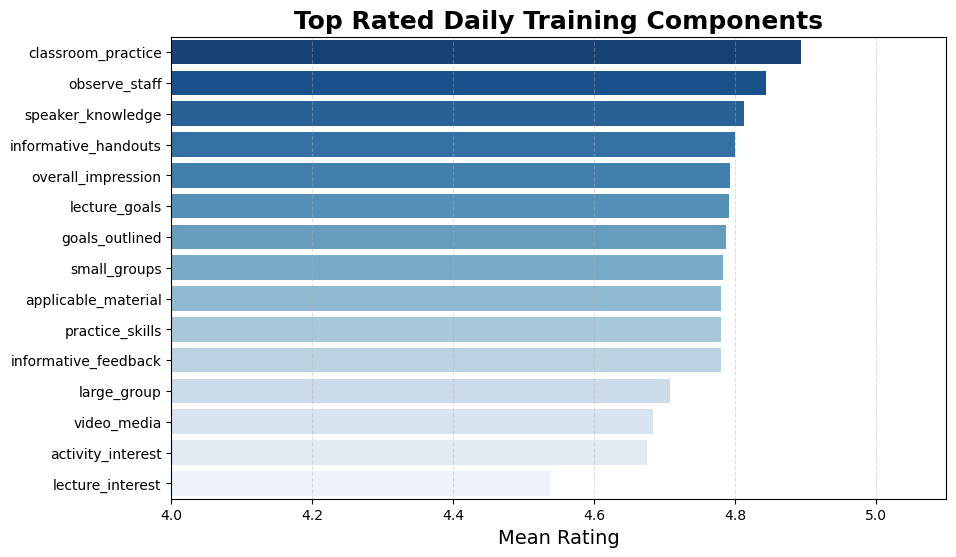

Saved: hands_plots/top_rated_satisfaction.png


classroom_practice      4.893443
observe_staff           4.844262
speaker_knowledge       4.813008
informative_handouts    4.800000
overall_impression      4.793388
lecture_goals           4.791667
goals_outlined          4.786885
small_groups            4.783333
applicable_material     4.780488
practice_skills         4.780488
informative_feedback    4.780488
large_group             4.707317
video_media             4.682927
activity_interest       4.674797
lecture_interest        4.536585
dtype: float64

<Figure size 640x480 with 0 Axes>

In [51]:
item_means = df_daily_eval[daily_items].mean().sort_values(ascending=False)

def save_plot(name=None):
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        name = f"plot_{timestamp}.png"
    path = os.path.join(SAVE_FOLDER, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved: {path}")

plt.figure(figsize=(10,6))
sns.barplot(x=item_means.values, y=item_means.index, palette="Blues_r")
plt.title("Top Rated Daily Training Components", fontsize=18, weight='bold')
plt.xlabel("Mean Rating", fontsize=14)
plt.xlim(4.0, 5.1)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()
save_plot("top_rated_satisfaction.png")

item_means

Saved: hands_plots/distribution_satisfaction.png


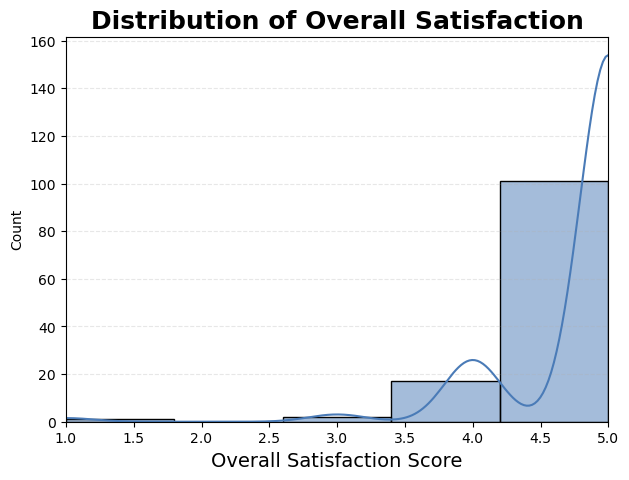

In [50]:
def save_plot(name=None):
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        name = f"plot_{timestamp}.png"
    path = os.path.join(SAVE_FOLDER, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved: {path}")
    
plt.figure(figsize=(7,5))
sns.histplot(df_daily_eval["overall_impression"], bins=5, kde=True, color="#4a7bb7")
plt.title("Distribution of Overall Satisfaction", fontsize=18, weight='bold')
plt.xlabel("Overall Satisfaction Score", fontsize=14)
plt.ylabel("Count")
plt.xlim(1,5)
plt.grid(axis='y', linestyle='--', alpha=0.3)
save_plot("distribution_satisfaction.png")
plt.show()

Saved: hands_plots/top_rated_satisfaction.png


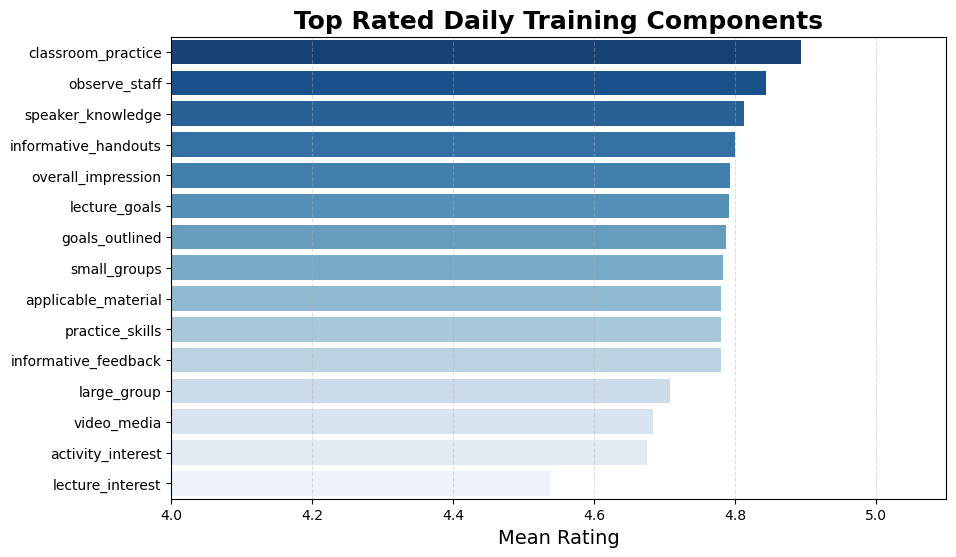

In [54]:
item_means = df_daily_eval[daily_items].mean().sort_values(ascending=False)

# ----- SAVE FUNCTION -----
def save_plot(name=None):
    if name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        name = f"plot_{timestamp}.png"
    path = os.path.join(SAVE_FOLDER, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved: {path}")

# ----- PLOT -----
plt.figure(figsize=(10,6))
sns.barplot(x=item_means.values, y=item_means.index, palette="Blues_r")
plt.title("Top Rated Daily Training Components", fontsize=18, weight='bold')
plt.xlabel("Mean Rating", fontsize=14)
plt.xlim(4.0, 5.1)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# SAVE BEFORE SHOW
save_plot("top_rated_satisfaction.png")

plt.show()   # show AFTER saving